# `Промышленное машинное обучение на Spark`
## `Задание 03: Spark Details`

<span style="color:red">Дедлайн:  00:00</span>

<span style="color:red">Заполненный ноутбук присылать на почту <b>ekolmagorov98@yandex.ru</b> с темой письма <b>[HSE Spark 2024][Задание 03][ФИО]</b>.</span>

In [1]:
! pip install pyspark pyarrow


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import datetime

from typing import List, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300

import pyspark
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '6g')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/07 05:45:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Скачаем и распакуем данные из соревнования [Web Traffic Time Series Forecasting](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/leaderboard).


In [5]:
import json
import requests
import subprocess
import zipfile

folder_url = 'https://disk.yandex.lt/d/v2DatluRGmU2Ng'
file_url = '/web-traffic-time-series-forecasting.zip'
# запрос ссылки на скачивание
response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download',
                 params={'public_key': folder_url, 'path': file_url}) 
# 'парсинг' ссылки на скачивание
data_link = response.json()['href'] 	

filename = 'web-traffic-time-series-forecasting.zip'
# путь куда распакуются данные
path = "./web-traffic-time-series-forecasting"

# запускаем скачивание вызовом команды wget из python
subprocess.run(
    ['wget', '-O', filename, data_link], # команда для исполнения
    stdout=subprocess.DEVNULL, # убираем печать отладочной информации
    stderr=subprocess.STDOUT
)

CompletedProcess(args=['wget', '-O', 'web-traffic-time-series-forecasting.zip', 'https://downloader.disk.yandex.ru/disk/6bdeb74ff4313b5198972e242e2c3138c38c455b2c59738e1fc193bdd1374775/653ceff4/qo_oUU0UNiEpD-z6-zCIga3GXt2EiW2xTVJ1RiRfCBBWULdm5VoxSPW_lynbN7Vp8b68kopjg19lQaQ8d2qbgg%3D%3D?uid=0&filename=web-traffic-time-series-forecasting.zip&disposition=attachment&hash=E49MtubvUrb12FBU2QEZgwKTWY0nBRgBDJOGkLQys5mIjn242W1EcdqTcysdGxI5q/J6bpmRyOJonT3VoXnDag%3D%3D%3A/web-traffic-time-series-forecasting.zip&limit=0&content_type=application%2Fzip&owner_uid=1199758960&fsize=611829090&hid=6f34fc31315ec0d6f4fa5b750d2e968e&media_type=compressed&tknv=v2'], returncode=0)

В этом датасете для все таблицы заархивированы, поэтому произвём их распаковку в директорию web-traffic-time-series-forecasting

In [6]:
! unzip web-traffic-time-series-forecasting.zip -d web-traffic-time-series-forecasting
! unzip web-traffic-time-series-forecasting/key_1.csv.zip -d web-traffic-time-series-forecasting
! unzip web-traffic-time-series-forecasting/key_2.csv.zip -d web-traffic-time-series-forecasting
! unzip web-traffic-time-series-forecasting/train_1.csv.zip -d web-traffic-time-series-forecasting
! unzip web-traffic-time-series-forecasting/train_2.csv.zip -d web-traffic-time-series-forecasting
! unzip web-traffic-time-series-forecasting/sample_submission_1.csv.zip -d web-traffic-time-series-forecasting
! unzip web-traffic-time-series-forecasting/sample_submission_2.csv.zip -d web-traffic-time-series-forecasting

# тк все данные уже распакованы, то удалим ненужные далее архивы с данными
! rm -rf web-traffic-time-series-forecasting.zip
! rm -rf web-traffic-time-series-forecasting/sample_submission_1.csv.zip 
! rm -rf web-traffic-time-series-forecasting/sample_submission_2.csv.zip 
! rm -rf web-traffic-time-series-forecasting/key_1.csv.zip web-traffic-time-series-forecasting/key_2.csv.zip
! rm -rf web-traffic-time-series-forecasting/train_1.csv.zip web-traffic-time-series-forecasting/train_2.csv.zip 

Archive:  web-traffic-time-series-forecasting.zip
  inflating: web-traffic-time-series-forecasting/key_1.csv.zip  
  inflating: web-traffic-time-series-forecasting/key_2.csv.zip  
  inflating: web-traffic-time-series-forecasting/sample_submission_1.csv.zip  
  inflating: web-traffic-time-series-forecasting/sample_submission_2.csv.zip  
  inflating: web-traffic-time-series-forecasting/train_1.csv.zip  
  inflating: web-traffic-time-series-forecasting/train_2.csv.zip  
Archive:  web-traffic-time-series-forecasting/key_1.csv.zip
  inflating: web-traffic-time-series-forecasting/key_1.csv  
Archive:  web-traffic-time-series-forecasting/key_2.csv.zip
  inflating: web-traffic-time-series-forecasting/key_2.csv  
Archive:  web-traffic-time-series-forecasting/train_1.csv.zip
  inflating: web-traffic-time-series-forecasting/train_1.csv  
Archive:  web-traffic-time-series-forecasting/train_2.csv.zip
  inflating: web-traffic-time-series-forecasting/train_2.csv  
Archive:  web-traffic-time-series-fo

In [7]:
# посмотрим на содержимое папки
! ls web-traffic-time-series-forecasting

key_1.csv  sample_submission_1.csv  train_1.csv
key_2.csv  sample_submission_2.csv  train_2.csv


Загрузим информацию о просмотрах страниц Википедии по дням в виде DataFrame:

In [5]:
# Сконструируем схему DataFrame в явном виде
# Это необходимо для более простого заполнения пропусков
#   так по умолчанию все колонки с пропусками определяются
#   как строковые
schema = T.StructType()
schema.add('Page', T.StringType())

delta = datetime.timedelta(days=1)
date = datetime.date.fromisoformat('2015-07-01')
for _ in range(803):
    schema.add(date.isoformat(), T.IntegerType())
    date += delta

df = (
    spark.read.format('csv')
        .option('header', True)
        .option('sep', ',')
        .schema(schema)
        .load('./web-traffic-time-series-forecasting/train_2.csv')
        .fillna(0.0)
).cache()

df.limit(5).toPandas()

23/02/07 05:46:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,19,33,33,18,16,27,29,23,54,38
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,32,30,11,19,54,25,26,23,13,81
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,6,6,7,2,4,7,3,4,7,6
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,...,7,19,19,9,6,16,19,30,38,4
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,16,16,19,9,20,23,28,14,8,7


***Замечание:*** Используйте метод `cache` для сохранения промежуточных результатов, которые Вы планируете переиспользовать!

**Задание 01:** Разбейте колонку `Page` в соответствии со схемой в описании данных (`name_project_access_agent`). В результате нужно составить DataFrame из $5$ колонок: `Page`, `Name`, `Project`, `Access`, `Agent`.

*Замечание 0*: Не используйте UDF.

*Замечание 1*: Название страницы (`Name`) может содержать любое количество символов `_`.

*Замечание 2*: Некоторые строки "обёрнуты" в двойные кавычки. Желательно первой трансформацией над колонкой `Page` из всех таких строк убрать лишние внешние кавычки.

*Замечание 3:* Строки, которые не удовлетворяют указанному паттерну, нужно выделить в отдельный DataFrame.

*Замечание 4:* Для удобства, используйте возможность сохранения колоночных выражений в переменные.

*Подсказка 1:* Подстроки переменной длины можно выделять [следующим образом](https://stackoverflow.com/questions/53153149/remove-last-few-characters-in-pyspark-dataframe-column).

*Подсказка 2:* Для решения задачи могут пригодиться функции `.when().otherwise()`, `substring`, `size`, `expr`, `split`, `array_join`, `slice`, `element_at`.

In [6]:
### YOUR CODE HERE:
...
articles = ...
corrupted_articles = ...

Проверьте, что предобработка выполнена верно:

In [7]:
corrupted_articles.show(truncate=False)

+---------+
|Page     |
+---------+
|"""Awaken|
|"""Awaken|
|"""Awaken|
+---------+



In [8]:
articles.groupBy('Project').count().show(truncate=False)
articles.groupBy('Access').count().show(truncate=False)
articles.groupBy('Agent').count().show(truncate=False)

+---------------------+-----+
|Project              |count|
+---------------------+-----+
|en.wikipedia.org     |24105|
|zh.wikipedia.org     |17229|
|fr.wikipedia.org     |17802|
|commons.wikimedia.org|10555|
|www.mediawiki.org    |7300 |
|ru.wikipedia.org     |15022|
|de.wikipedia.org     |18547|
|ja.wikipedia.org     |20431|
|es.wikipedia.org     |14069|
+---------------------+-----+

+----------+-----+
|Access    |count|
+----------+-----+
|desktop   |34808|
|all-access|74313|
|mobile-web|35939|
+----------+-----+

+----------+------+
|Agent     |count |
+----------+------+
|all-agents|110148|
|spider    |34912 |
+----------+------+



**Задание 02:** Выполните unpivot исходных данных.

*Замечание 1*: Выражение для unpivot нужно сконструировать циклом по всем колонкам с датами.

*Замечание 2*: В колоночных строковых выражениях можно указывать колонки с произвольным названием при использовании экранирования. Например: ``` `2015-07-01` ```. 

In [9]:
date_columns = df.columns[1:]
### YOUR CODE HERE:
...

unpivot_df = ...

In [10]:
unpivot_df.show(10, truncate=False)

+---------------------------------------+----------+-----+
|Page                                   |Day       |Views|
+---------------------------------------+----------+-----+
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-01|18   |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-02|11   |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-03|5    |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-04|13   |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-05|14   |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-06|9    |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-07|9    |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-08|22   |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-09|26   |
|2NE1_zh.wikipedia.org_all-access_spider|2015-07-10|24   |
+---------------------------------------+----------+-----+
only showing top 10 rows



**Задание 03:** Для каждой записи в данных посчитайте среднее число просмотров за предыдущие $14$ дней.

*Замечание 1*: Используйте оконные функции.

*Замечание 2*: Для работы с датами можно использовать функцию `cast` для преобразования строки в timestamp.

*Замечание 3*: Проанализируйте [ответы `ZygD` и `zero323`](https://stackoverflow.com/questions/33207164/spark-window-functions-rangebetween-dates).

In [11]:
### YOUR CODE HERE:
...
unpivot_df = ...

unpivot_df.show(10, truncate=False)

+------------------------------------------------+----------+-----+------------------+
|Page                                            |Day       |Views|Mean Views        |
+------------------------------------------------+----------+-----+------------------+
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-01|30   |30.0              |
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-02|35   |32.5              |
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-03|31   |32.0              |
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-04|20   |29.0              |
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-05|25   |28.2              |
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-06|38   |29.833333333333332|
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-07|40   |31.285714285714285|
|17._November_de.wikipedia.org_desktop_all-agents|2015-07-08|26   |30.625            |
|17._November_de.wikipedia.org_desktop_all-

**Задание 04:** По исходным данным посчитайте суммарное число просмотров за все дни. Отсортируйте страницы по убыванию числа просмотров.
    
*Замечание*: Используйте RDD API.

In [12]:
### YOUR CODE HERE:
views_rdd = ...

In [13]:
most_viewed = views_rdd.take(10)
most_viewed

[('Main_Page_en.wikipedia.org_all-access_all-agents', 17196257412),
 ('Main_Page_en.wikipedia.org_desktop_all-agents', 12920351037),
 ('Main_Page_en.wikipedia.org_mobile-web_all-agents', 3838848757),
 ('Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 2267327557),
 ('Special:Search_en.wikipedia.org_all-access_all-agents', 1900465449),
 ('Wikipedia:Hauptseite_de.wikipedia.org_mobile-web_all-agents', 1424831230),
 ('Special:Search_en.wikipedia.org_desktop_all-agents', 1403199006),
 ('Заглавная_страница_ru.wikipedia.org_all-access_all-agents', 1301733089),
 ('Wikipédia:Accueil_principal_fr.wikipedia.org_all-access_all-agents',
  1151181482),
 ('Wikipedia:Portada_es.wikipedia.org_all-access_all-agents', 958693538)]

**Задание 05:** Возьмите страницу с самым большим числом просмотром. Изобразите на одном графике динамику просмотров и средних просмотров за $14$ дней по дням.

In [14]:
### YOUR CODE HERE:
most_viewed_data = ...

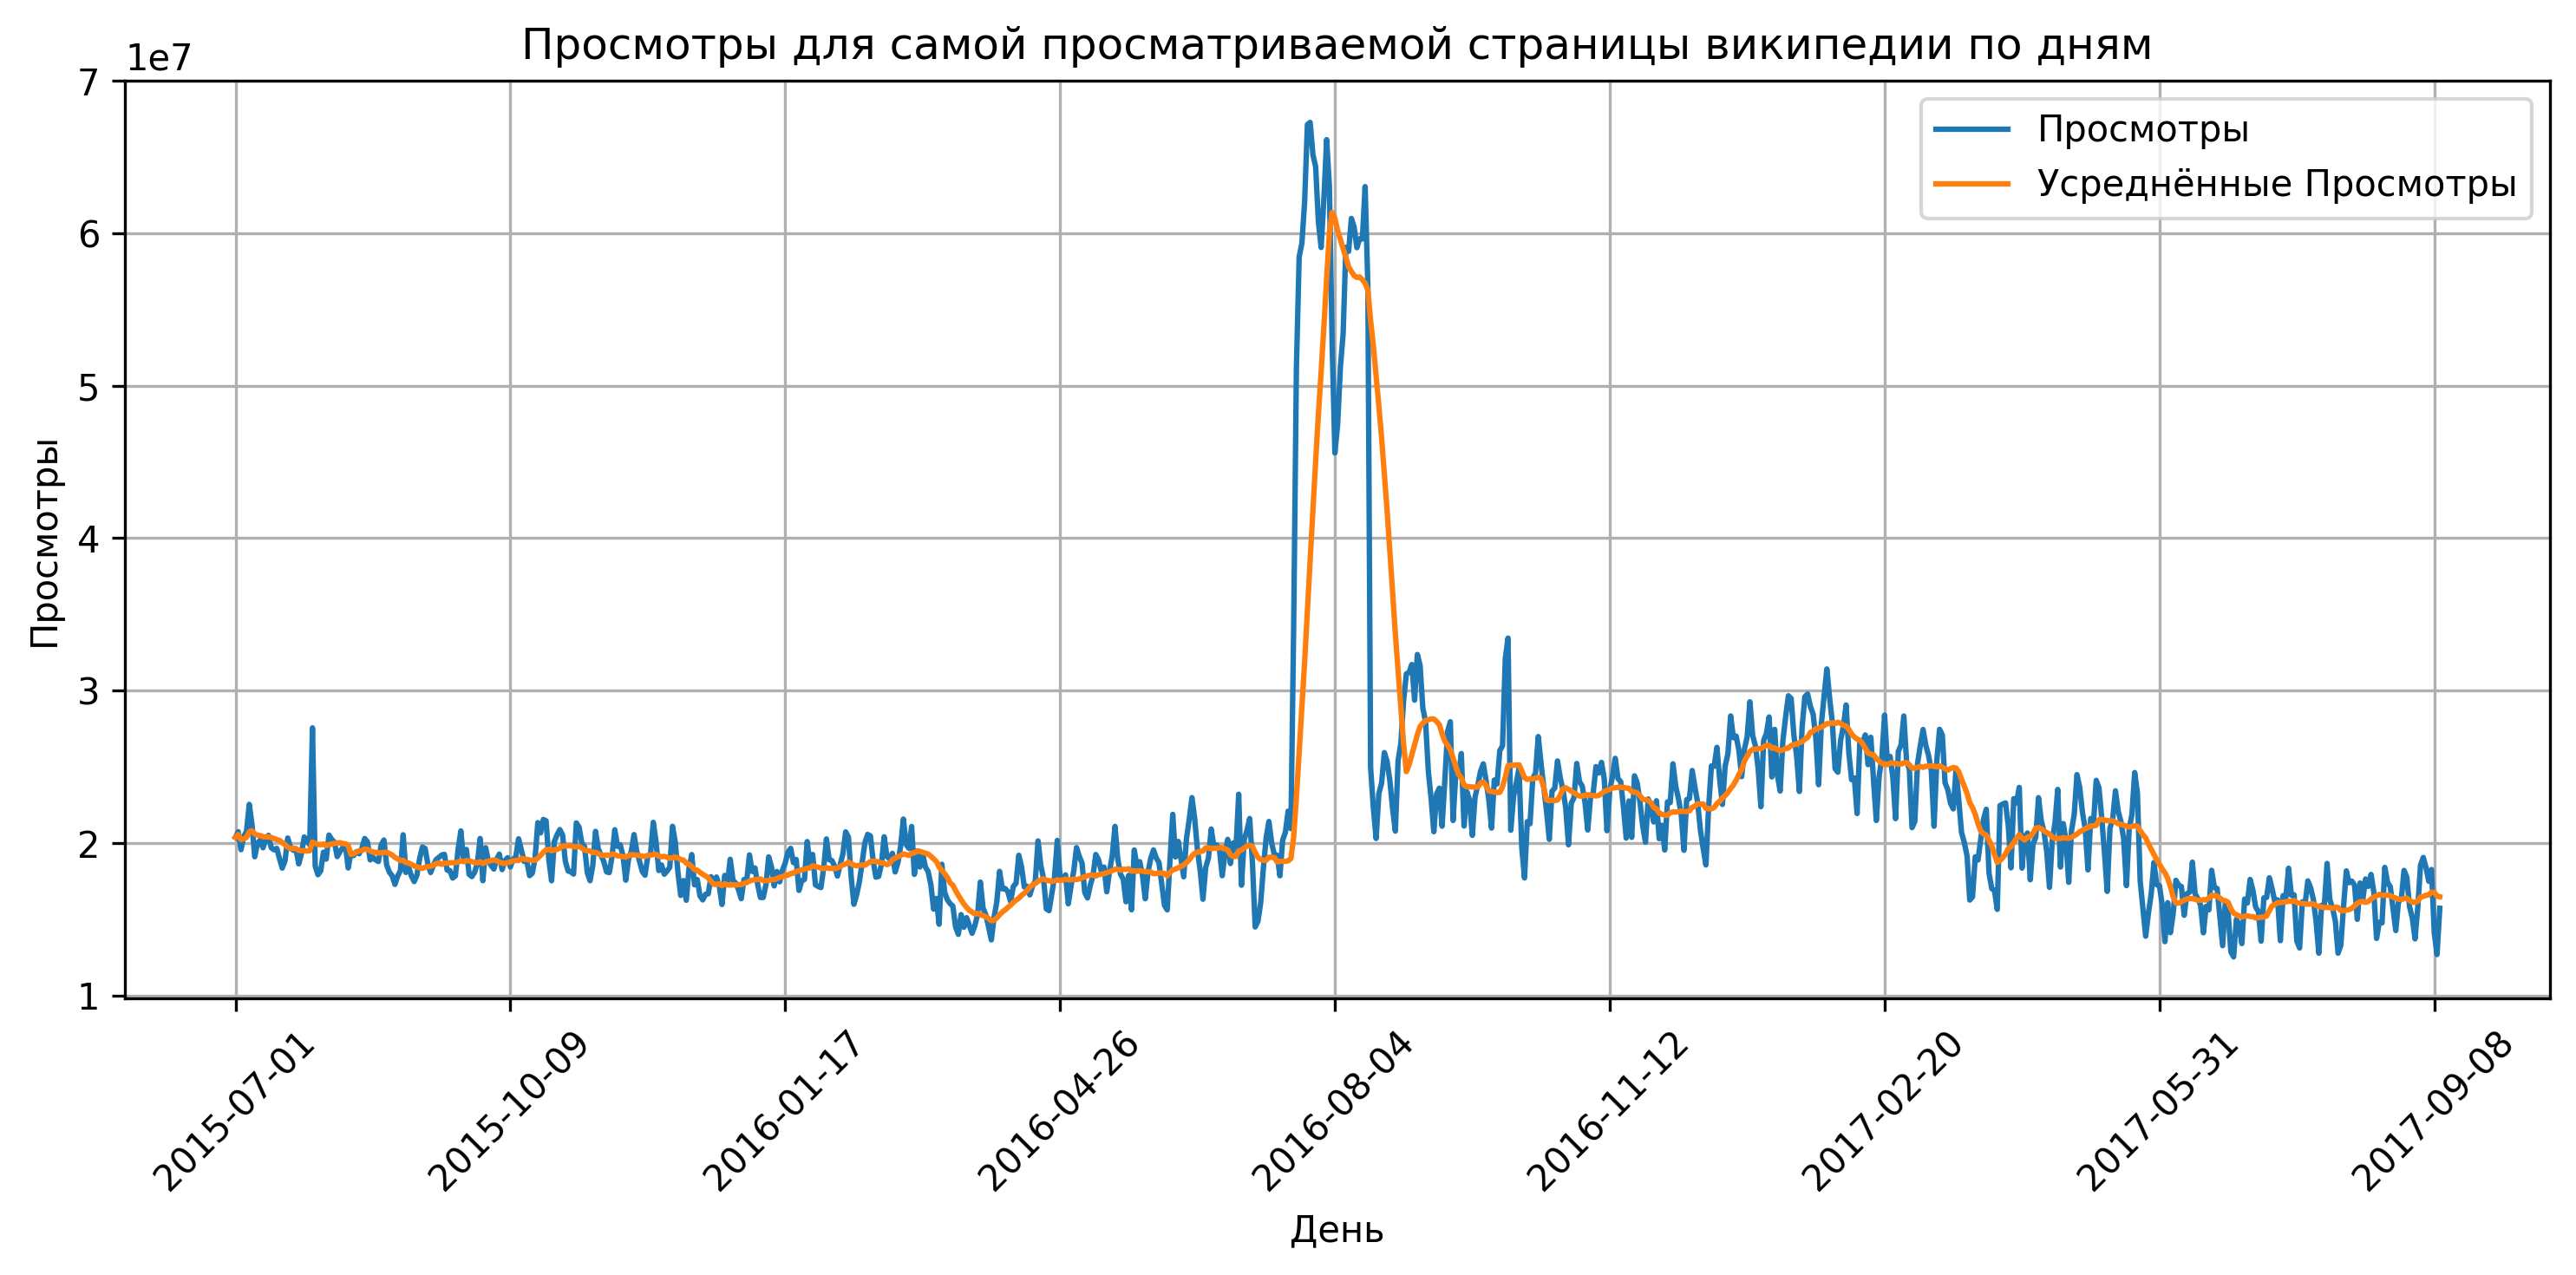

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

### YOUR CODE HERE:
...

fig.tight_layout()
plt.show()

**Задание 06:** Используя информацию из DataFrame `articles`, посчитайте для каждой записи в разрезе Project/Access максимальное число просмотров за все предшествующие дни.

In [16]:
### YOUR CODE HERE:
...
stats_df = ...
stats_df.show(10, truncate=False)

+-----------------+-------+----------+---------+
|Project          |Access |Day       |Max Views|
+-----------------+-------+----------+---------+
|www.mediawiki.org|desktop|2015-07-01|30476    |
|www.mediawiki.org|desktop|2015-07-02|36043    |
|www.mediawiki.org|desktop|2015-07-03|36043    |
|www.mediawiki.org|desktop|2015-07-04|36043    |
|www.mediawiki.org|desktop|2015-07-05|36043    |
|www.mediawiki.org|desktop|2015-07-06|36043    |
|www.mediawiki.org|desktop|2015-07-07|39979    |
|www.mediawiki.org|desktop|2015-07-08|39979    |
|www.mediawiki.org|desktop|2015-07-09|39979    |
|www.mediawiki.org|desktop|2015-07-10|48142    |
+-----------------+-------+----------+---------+
only showing top 10 rows




[Stage 41:========================================>            (154 + 12) / 200]



**Задание 07:** Изобразите динамику максимального числа просмотров за предшествующие дни в разрезе Project/Access.

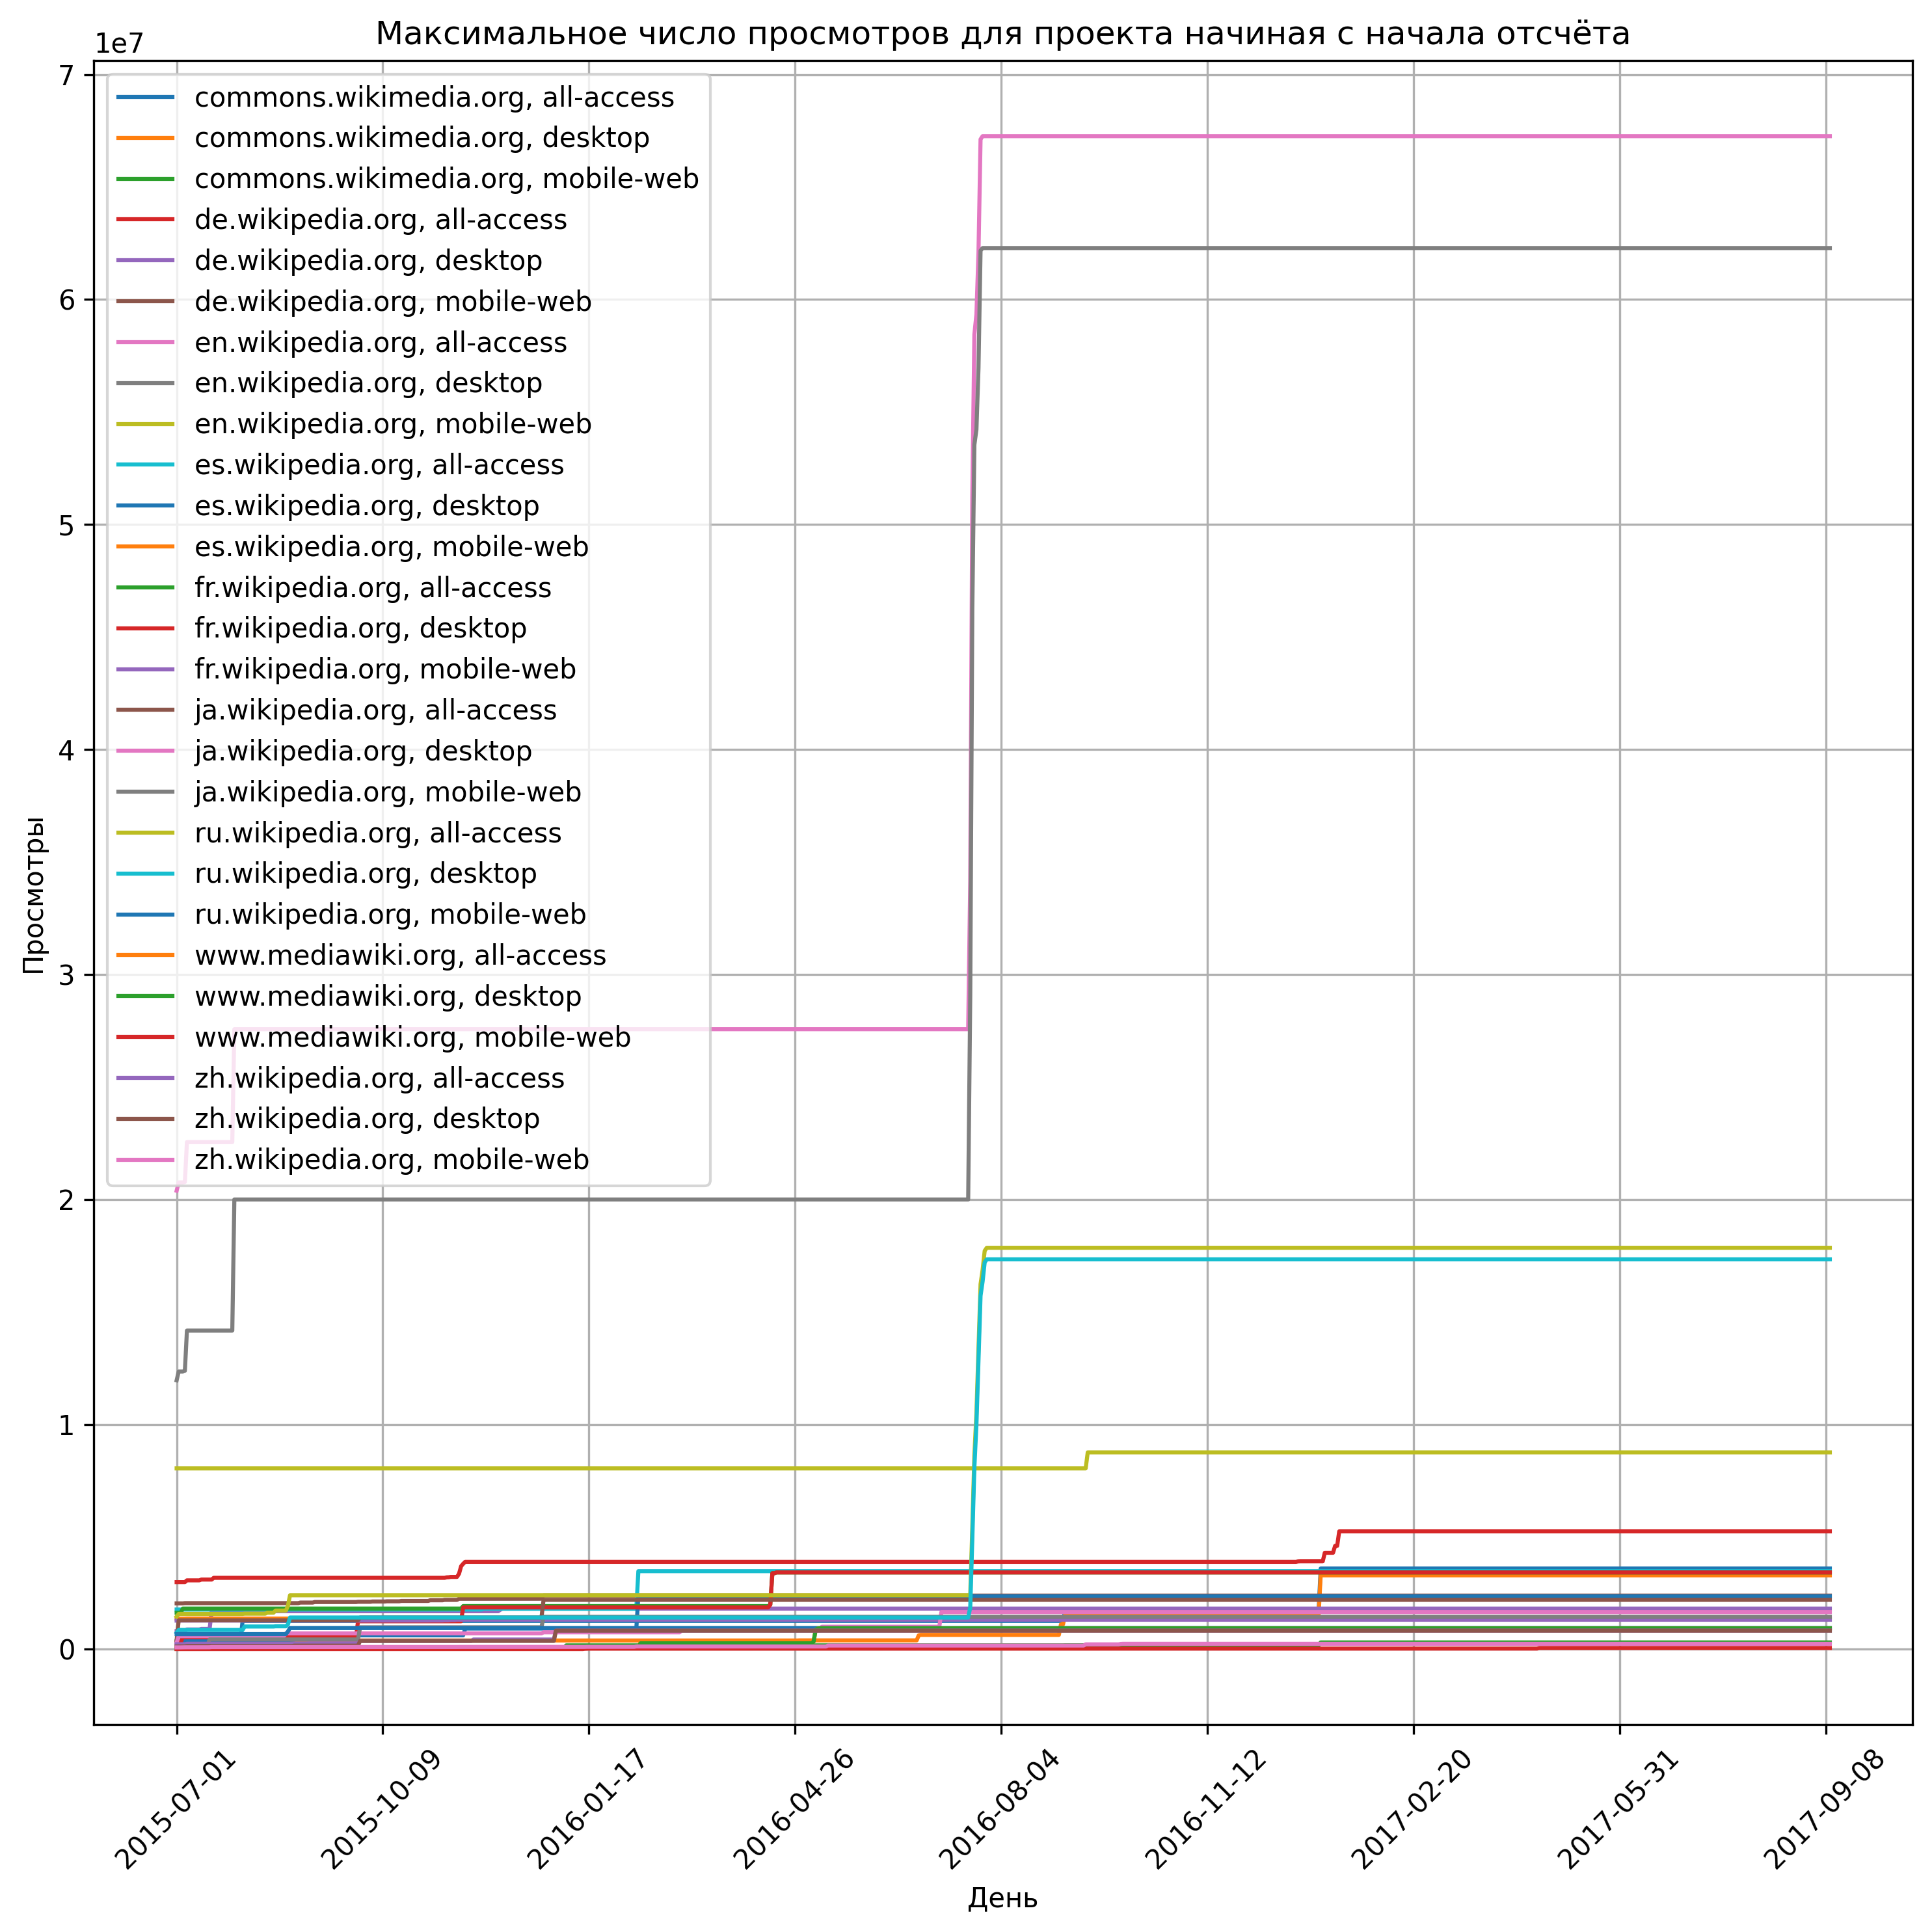

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

### YOUR CODE HERE:
...

fig.tight_layout()
plt.show()

**Задание 08:** Рассмотрим задачу предсказания числа просмотров конкретной страницы на следующий день. Рассмотрим два простейших варианта предсказания:
* Среднее за $7$ предыдущих дней
* Лаг с шагом $1$ — значение за предыдущий день

Создайте две колонки, которые будут содержать указанные варианты предсказания числа просмотров.

*Замечание:* Если предсказание не определено, то используйте среднее число просмотров страницы.

*Подсказка:* Вам могут пригодиться функции `cast`, `coalesce`.

In [18]:
### YOUR CODE HERE:
...
unpivot_with_predictions_df = ...

unpivot_with_predictions_df.show(10)

+--------------------+----------+-----+------------------+------------------+------------------+
|                Page|       Day|Views|        Mean Views|   Mean Prediction|    Lag Prediction|
+--------------------+----------+-----+------------------+------------------+------------------+
|17._November_de.w...|2015-07-01|   30|              30.0|117.36363636363636|117.36363636363636|
|17._November_de.w...|2015-07-02|   35|              32.5|              30.0|              30.0|
|17._November_de.w...|2015-07-03|   31|              32.0|              32.5|              35.0|
|17._November_de.w...|2015-07-04|   20|              29.0|              32.0|              31.0|
|17._November_de.w...|2015-07-05|   25|              28.2|              29.0|              20.0|
|17._November_de.w...|2015-07-06|   38|29.833333333333332|              28.2|              25.0|
|17._November_de.w...|2015-07-07|   40|31.285714285714285|29.833333333333332|              38.0|
|17._November_de.w...|2015-07-

**Задание 09:** Оценим пролучившиеся модели. Для этого посчитаем метрику качества **SMAPE**:

$$
\text{SMAPE} = \frac{200\%}{n} \sum\limits_{i=1}^{n} \frac{|y_{i} - \hat{y}_{i}|}{|y_{i}| + |\hat{y}_{i}|}
$$

Где $y_{i}$, $\hat{y}_{i}$ — истинный ответ (таргет) и предсказание модели соответственно.

Подроднее прочитать про [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) и [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) можно на Википедии, а также у [А.Г. Дьяконова](https://alexanderdyakonov.files.wordpress.com/2018/10/book_08_metrics_12_blog1.pdf).

Для удобства реализуем подсчёт метрики в виде отдельной функции.

In [19]:
def count_smape(
    df: pyspark.sql.dataframe.DataFrame, 
    target_col: str, prediction_col: str,
    groups: Optional[List[str]]=None
) -> pyspark.sql.dataframe.DataFrame:
    '''
     :param pyspark.sql.dataframe.DataFrame df: Датафрейм для которого считается SMAPE
     :param str target_col: Название колонки в которой находятся истинные значения целевой переменной
     :param str prediction_col: Название колонки в которой находятся предсказания
     :param Optional[List[str]] groups: Список колонок по которым нужно выполнить агрегацию
         значений метрики для отдельных объектов выборки. Если `groups is None` нужно вернуть 
         среднее по всей выборке
     :return pyspark.sql.dataframe.DataFrame: 
    '''
    ### YOUR CODE HERE:
    ...
    
    if groups is None:
        ### YOUR CODE HERE:
        ...
    else:
        ### YOUR CODE HERE:
        ...

In [20]:
count_smape(unpivot_with_predictions_df, 'Views', 'Lag Prediction').show()
count_smape(unpivot_with_predictions_df, 'Views', 'Mean Prediction').show()

+-----------------+
|            SMAPE|
+-----------------+
|36.17647072185545|
+-----------------+



+-----------------+
|            SMAPE|
+-----------------+
|36.81491846337296|
+-----------------+




[Stage 50:=============================================>       (173 + 12) / 200]



In [21]:
count_smape(
    unpivot_with_predictions_df.join(articles, on='Page', how='inner'), 
    'Views', 'Lag Prediction', groups=['Project']
).show(10, truncate=False)
count_smape(
    unpivot_with_predictions_df.join(articles, on='Page', how='inner'), 
    'Views', 'Mean Prediction', groups=['Project']
).show(10, truncate=False)

+---------------------+------------------+
|Project              |SMAPE             |
+---------------------+------------------+
|commons.wikimedia.org|59.6298498614523  |
|en.wikipedia.org     |32.63956020407227 |
|www.mediawiki.org    |62.258139736306596|
|de.wikipedia.org     |37.319961625581655|
|es.wikipedia.org     |32.86101430289916 |
|ja.wikipedia.org     |32.03821442890808 |
|ru.wikipedia.org     |26.811208160514123|
|zh.wikipedia.org     |33.59862386011561 |
|fr.wikipedia.org     |36.592989194753194|
+---------------------+------------------+



+---------------------+------------------+
|Project              |SMAPE             |
+---------------------+------------------+
|commons.wikimedia.org|63.557871053100186|
|en.wikipedia.org     |32.99681011925371 |
|www.mediawiki.org    |59.3623870211388  |
|de.wikipedia.org     |36.822607901766446|
|es.wikipedia.org     |33.61237523176791 |
|ja.wikipedia.org     |33.984040552171976|
|ru.wikipedia.org     |27.92595060910766 |
|zh.wikipedia.org     |33.1297890217529  |
|fr.wikipedia.org     |35.91425429634095 |
+---------------------+------------------+



**Задание 10:** Определите, какая из двух моделей работает лучше. Одинаковый ли результат получается для разных Project? А для Action/Access?

In [22]:
### YOUR CODE HERE:
...

**Ответ:** Ваш ответ здесь.